In [140]:
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import random
import tqdm
import numpy as np

# Visualize the datasets and manage the dataset

In [2]:
edges = pd.read_csv("wikigraph_reduced.csv", sep="\t", usecols = ["0", "1"])
edges.columns = ["source", "dest"]
edges.head()

,source,dest
0,95,1185516
1,108,1059989
2,108,1062426
3,108,1161925
4,134,541222


Read the pages names.

In [3]:
pages_names = pd.read_csv("wiki-topcats-page-names.txt", names=["node name"])
pages_names

pages_names['node'] = [s.split()[0] for s in list(pages_names['node name']) ]
pages_names['name'] = [' '.join(s.split()[1:]) for s in list(pages_names['node name'])]

pages_names = pages_names.set_index("node").drop('node name', axis=1)
pages_names

,name
node,
0,Chiasmal syndrome
1,Kleroterion
2,Pinakion
3,LyndonHochschildSerre spectral sequence
4,Zariski's main theorem
...,...
1791484,Noadiah Russell (Yale founder)
1791485,Cornus officinalis
1791486,Peter Grummitt


Read each line of the "wiki-topcats-categories.txt" and create the dataset

In [31]:
categories = pd.read_csv("wiki-topcats-categories.txt", sep=";", names = ["Category", "Pages List"])
categories["Category"] = categories.Category.apply(lambda x: x[9:])
categories["Pages List"] = categories["Pages List"].apply(lambda x: x.split())
categories['length'] = [len(x) for x in categories['Pages List']]
# Removes the categories whose number of articles in less than 5000 and more than 30000.
categories = categories.loc[(categories['length']>=5000) & (categories['length']<=30000)]
categories

,Category,Pages List,length
868,English_footballers,"[22860, 28411, 28961, 28979, 29264, 29573, 295...",9237
869,The_Football_League_players,"[14003, 23536, 27109, 27348, 27459, 27989, 280...",9467
876,Association_football_forwards,"[26876, 26877, 26879, 26887, 26892, 26904, 269...",6959
900,Association_football_midfielders,"[14003, 15291, 23536, 26880, 26882, 26885, 268...",8270
949,Association_football_defenders,"[15217, 22860, 26873, 26878, 26881, 26898, 269...",6668
2791,Harvard_University_alumni,"[77, 1013, 1271, 1663, 1779, 1843, 2212, 3193,...",6154
4160,Major_League_Baseball_pitchers,"[79, 24213, 33054, 37167, 53973, 63107, 69823,...",6580
5619,Members_of_the_United_Kingdom_Parliament_for_E...,"[29098, 29493, 29585, 30255, 30389, 30505, 306...",6546
6067,Indian_films,"[1308, 29286, 53565, 70274, 70275, 70797, 1233...",5913
6795,Year_of_death_missing,"[98, 126, 227, 1823, 2170, 2223, 13215, 14003,...",7851


In [33]:
categories=categories.reset_index()
categories

,level_0,index,Category,Pages List,length
0,0,868,English_footballers,"[22860, 28411, 28961, 28979, 29264, 29573, 295...",9237
1,1,869,The_Football_League_players,"[14003, 23536, 27109, 27348, 27459, 27989, 280...",9467
2,2,876,Association_football_forwards,"[26876, 26877, 26879, 26887, 26892, 26904, 269...",6959
3,3,900,Association_football_midfielders,"[14003, 15291, 23536, 26880, 26882, 26885, 268...",8270
4,4,949,Association_football_defenders,"[15217, 22860, 26873, 26878, 26881, 26898, 269...",6668
5,5,2791,Harvard_University_alumni,"[77, 1013, 1271, 1663, 1779, 1843, 2212, 3193,...",6154
6,6,4160,Major_League_Baseball_pitchers,"[79, 24213, 33054, 37167, 53973, 63107, 69823,...",6580
7,7,5619,Members_of_the_United_Kingdom_Parliament_for_E...,"[29098, 29493, 29585, 30255, 30389, 30505, 306...",6546
8,8,6067,Indian_films,"[1308, 29286, 53565, 70274, 70275, 70797, 1233...",5913
9,9,6795,Year_of_death_missing,"[98, 126, 227, 1823, 2170, 2223, 13215, 14003,...",7851


In [35]:
categories=categories.drop(columns=['level_0','index','length'])
categories

,Category,Pages List
0,English_footballers,"[22860, 28411, 28961, 28979, 29264, 29573, 295..."
1,The_Football_League_players,"[14003, 23536, 27109, 27348, 27459, 27989, 280..."
2,Association_football_forwards,"[26876, 26877, 26879, 26887, 26892, 26904, 269..."
3,Association_football_midfielders,"[14003, 15291, 23536, 26880, 26882, 26885, 268..."
4,Association_football_defenders,"[15217, 22860, 26873, 26878, 26881, 26898, 269..."
5,Harvard_University_alumni,"[77, 1013, 1271, 1663, 1779, 1843, 2212, 3193,..."
6,Major_League_Baseball_pitchers,"[79, 24213, 33054, 37167, 53973, 63107, 69823,..."
7,Members_of_the_United_Kingdom_Parliament_for_E...,"[29098, 29493, 29585, 30255, 30389, 30505, 306..."
8,Indian_films,"[1308, 29286, 53565, 70274, 70275, 70797, 1233..."
9,Year_of_death_missing,"[98, 126, 227, 1823, 2170, 2223, 13215, 14003,..."


You will notice that one article might belong to a single category or multiple ones. In the case of multiple appearance, you break the ties uniformly at random. Please, do it before solving any task in the homework.

In [36]:
cats = list(categories["Category"])
pages_list = list(categories["Pages List"])

create a vocabulary in order to create the clean categories without replicates.

In [37]:
nodes = {}
for i, list_pages in enumerate(pages_list):
    for node in list_pages:
        if node not in nodes:
            nodes[node] = []
        nodes[node].append(i)

Choose uniformly at random a category where the page will be belong, then create the dictionary.

Remove also the categories that haven't any node in the graph.

In [38]:
sources = set(edges["source"])
dests = set(edges["dest"])
red_nodes = sources.union(dests)

In [39]:

nodes2 = defaultdict(list)
for node in nodes.keys():
    cat = random.sample(nodes[node], 1)[0]
    if int(node) in red_nodes:
        nodes2[cat].append(node)
    # else:
        # drop in the dataframe pages_names the useless node not present in the graph  

In [40]:
new_categories = pd.DataFrame()
new_categories['category'] = nodes2.keys()
new_categories['pages list'] = nodes2.values()

def set_category(x, categories):
    return categories.loc[x, "Category"]
    
new_categories["category"] = new_categories.category.apply(lambda x: set_category(x, categories)) # set the category not the integer value
new_categories

C:\Users\14193\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,category,pages list
0,English_footballers,"[28961, 33973, 48718, 48730, 72482, 72496, 725..."
1,The_Football_League_players,"[48583, 72488, 72532, 72555, 72567, 72579, 726..."
2,Year_of_death_missing,"[72528, 72589, 72609, 72852, 72862, 75258, 753..."
3,Association_football_forwards,"[72536, 72620, 72708, 72802, 72945, 73243, 733..."
4,Association_football_midfielders,"[72580, 73252, 73309, 73310, 74507, 75227, 754..."
5,Association_football_defenders,"[72629, 72747, 72798, 72820, 72943, 73090, 731..."
6,Year_of_birth_missing,"[73047, 75984, 93575, 93668, 343389, 672026, 6..."
7,Members_of_the_United_Kingdom_Parliament_for_E...,"[536702, 536438, 539018, 539130, 539674, 53977..."
8,Place_of_birth_missing_(living_people),"[75195, 1006344, 104383, 1354912, 1625870, 735..."
9,Harvard_University_alumni,"[1663, 1843, 3260, 3431, 11386, 11858, 12295, ..."


# RQ6

In [75]:
all = set(edges['source']).union(set(edges['dest']))

In [42]:
new_categories=new_categories.reset_index()
new_categories

,index,category,pages list
0,0,English_footballers,"[28961, 33973, 48718, 48730, 72482, 72496, 725..."
1,1,The_Football_League_players,"[48583, 72488, 72532, 72555, 72567, 72579, 726..."
2,2,Year_of_death_missing,"[72528, 72589, 72609, 72852, 72862, 75258, 753..."
3,3,Association_football_forwards,"[72536, 72620, 72708, 72802, 72945, 73243, 733..."
4,4,Association_football_midfielders,"[72580, 73252, 73309, 73310, 74507, 75227, 754..."
5,5,Association_football_defenders,"[72629, 72747, 72798, 72820, 72943, 73090, 731..."
6,6,Year_of_birth_missing,"[73047, 75984, 93575, 93668, 343389, 672026, 6..."
7,7,Members_of_the_United_Kingdom_Parliament_for_E...,"[536702, 536438, 539018, 539130, 539674, 53977..."
8,8,Place_of_birth_missing_(living_people),"[75195, 1006344, 104383, 1354912, 1625870, 735..."
9,9,Harvard_University_alumni,"[1663, 1843, 3260, 3431, 11386, 11858, 12295, ..."


In [105]:
l = len(new_categories)
for i in range(l):
    new_categories['pages list'][i] =  [ int(x) for x in new_categories['pages list'][i] ]

<ipython-input-105-51760a5ff589>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_categories['pages list'][i] =  [ int(x) for x in new_categories['pages list'][i] ]


In [113]:
new_categories

,index,category,pages list
0,0,English_footballers,"[28961, 33973, 48718, 48730, 72482, 72496, 725..."
1,1,The_Football_League_players,"[48583, 72488, 72532, 72555, 72567, 72579, 726..."
2,2,Year_of_death_missing,"[72528, 72589, 72609, 72852, 72862, 75258, 753..."
3,3,Association_football_forwards,"[72536, 72620, 72708, 72802, 72945, 73243, 733..."
4,4,Association_football_midfielders,"[72580, 73252, 73309, 73310, 74507, 75227, 754..."
5,5,Association_football_defenders,"[72629, 72747, 72798, 72820, 72943, 73090, 731..."
6,6,Year_of_birth_missing,"[73047, 75984, 93575, 93668, 343389, 672026, 6..."
7,7,Members_of_the_United_Kingdom_Parliament_for_E...,"[536702, 536438, 539018, 539130, 539674, 53977..."
8,8,Place_of_birth_missing_(living_people),"[75195, 1006344, 104383, 1354912, 1625870, 735..."
9,9,Harvard_University_alumni,"[1663, 1843, 3260, 3431, 11386, 11858, 12295, ..."


In [118]:
ls = len(edges)
for i in range(0,ls):
    for j in range(0,l):
        if edges['source'][i] in new_categories['pages list'][j]:
            edges['source'][i] = new_categories['category'][j]

<ipython-input-118-f850db2d92f1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges['source'][i] = new_categories['category'][j]


In [121]:
ls = len(edges)
for i in range(0,ls):
    for j in range(0,l):
        if edges['dest'][i] in new_categories['pages list'][j]:
            edges['dest'][i] = new_categories['category'][j]

In [123]:
newedge=edges.drop_duplicates()

In [124]:
newedge

,source,dest
0,Debut_albums,Place_of_birth_missing_(living_people)
1,Debut_albums,American_films
2,Debut_albums,American_film_actors
4,English-language_films,Members_of_the_United_Kingdom_Parliament_for_E...
5,English-language_films,American_film_actors
...,...,...
339428,American_television_actors,The_Football_League_players
444425,Debut_albums,Association_football_forwards
447615,Association_football_midfielders,Debut_albums
448639,Association_football_forwards,Black-and-white_films


In [128]:
import networkx as nx
sources= list(newedge['source'])
dests = list(newedge['dest'])
newG = nx.Graph()
for i in range(len(newedge)):
    newG.add_node(sources[i]) # source
    newG.add_node(dests[i]) # dest
    
    newG.add_edge(sources[i], dests[i], weight=1)

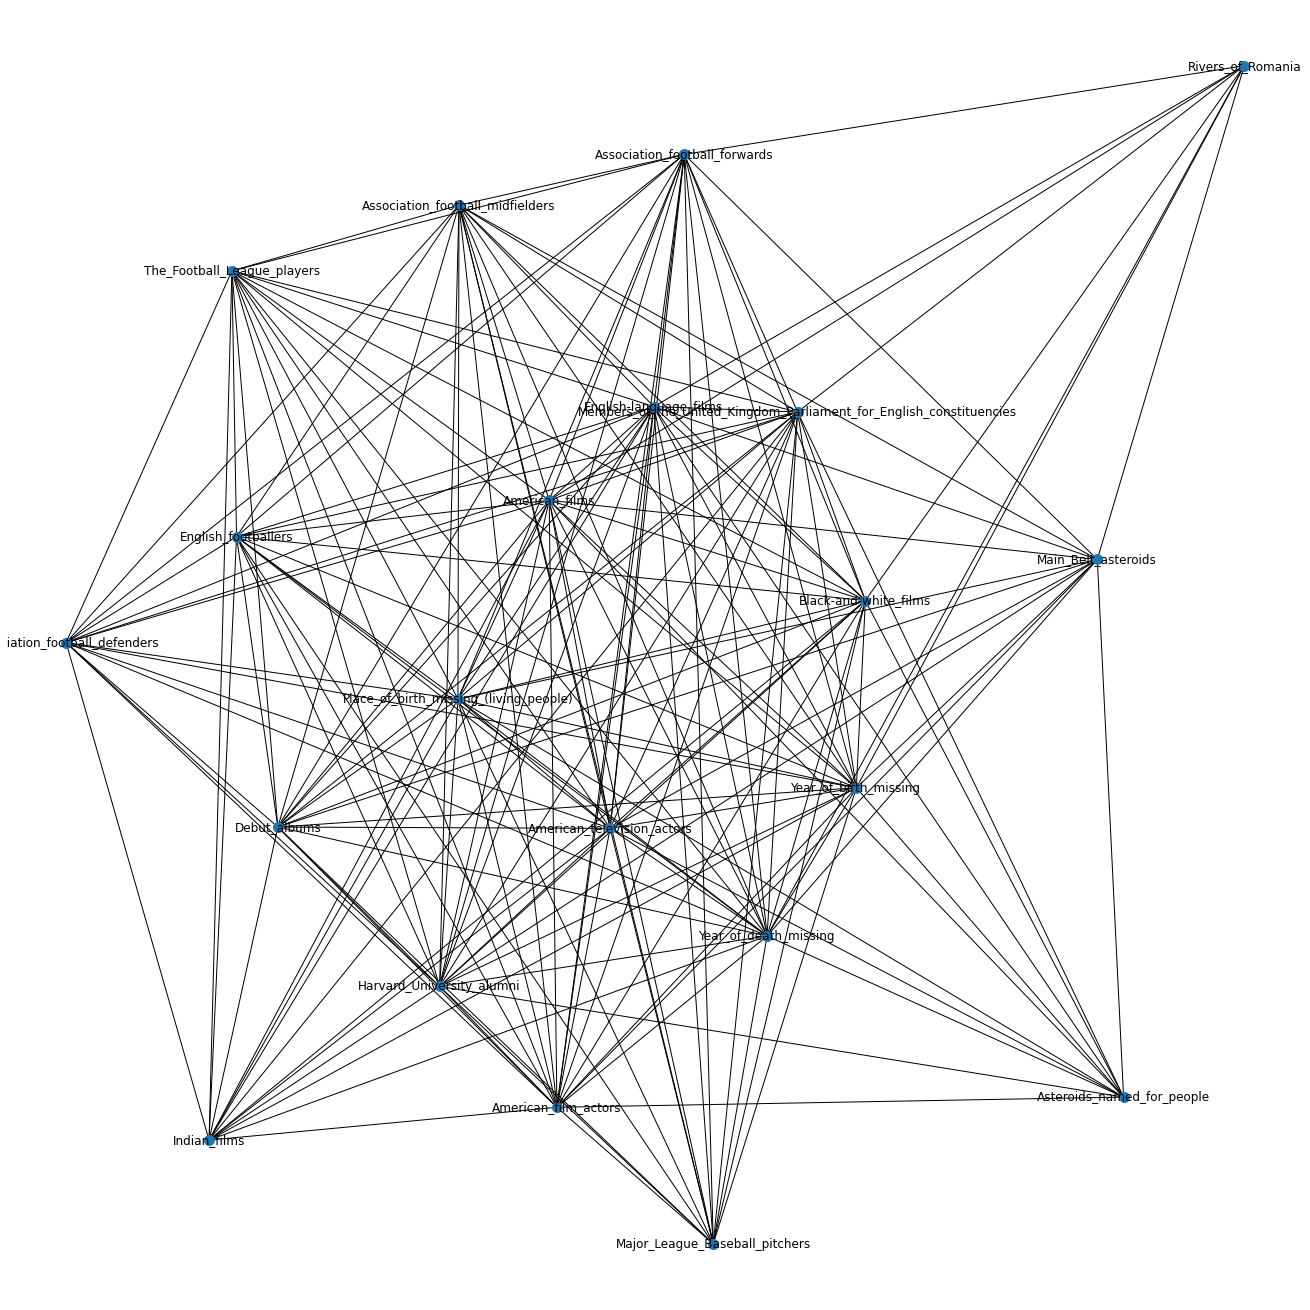

In [154]:
fig = plt.figure(figsize=(18,18))
nx.draw(newG, with_labels=True,node_size=100)
plt.show()

In [139]:
mt = nx.to_numpy_matrix(newG)

In [143]:

a = mt.A 
def graphMove(a):  # Construct transition matrix
    b = transpose(a)  # b=a.T
    c = zeros((a.shape), dtype=float)
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            c[i][j] = a[i][j] / (b[j].sum())  # Initial allocation
    return c


def firstPr(c):  # Initial pr value
    pr = zeros((c.shape[0], 1), dtype=float)  # store pr matrix
    for i in range(c.shape[0]):
        pr[i] = float(1) / c.shape[0]
    return pr

def pageRank(p, m, v):  # calculate pageRank
    while ((v == p * dot(m, v) + (
        1 - p) * v).all() == False):  
        #Determine whether the pr matrix converges
        v = p * dot(m, v) + (1 - p) * v
    return v


In [144]:
pageRank(0.85, graphMove(a), firstPr( graphMove(a))) 

array([[0.05066667],
       [0.05333333],
       [0.056     ],
       [0.05333333],
       [0.056     ],
       [0.05333333],
       [0.05333333],
       [0.05333333],
       [0.04533333],
       [0.03733333],
       [0.056     ],
       [0.032     ],
       [0.05066667],
       [0.048     ],
       [0.05066667],
       [0.056     ],
       [0.04266667],
       [0.048     ],
       [0.04      ],
       [0.04      ],
       [0.024     ]])

In [171]:
nodes = list(newG.nodes)

In [176]:
from tkinter import _flatten
Catlist = list(_flatten(pageRank(0.85, graphMove(a), firstPr( graphMove(a))).tolist()))

In [180]:
sortCat ={"category":nodes,"pagerank":Catlist}

In [181]:
df = pd.DataFrame(sortCat)
df

,category,pagerank
0,Debut_albums,0.050667
1,Place_of_birth_missing_(living_people),0.053333
2,American_films,0.056000
3,American_film_actors,0.053333
4,English-language_films,0.056000
5,Members_of_the_United_Kingdom_Parliament_for_E...,0.053333
6,American_television_actors,0.053333
7,Harvard_University_alumni,0.053333
8,The_Football_League_players,0.045333
9,Main_Belt_asteroids,0.037333


In [184]:
df.sort_values(by=['pagerank'],ascending=0)

,category,pagerank
10,Year_of_death_missing,0.056000
2,American_films,0.056000
4,English-language_films,0.056000
15,Year_of_birth_missing,0.056000
3,American_film_actors,0.053333
5,Members_of_the_United_Kingdom_Parliament_for_E...,0.053333
6,American_television_actors,0.053333
7,Harvard_University_alumni,0.053333
1,Place_of_birth_missing_(living_people),0.053333
12,Black-and-white_films,0.050667


In [188]:
def plot_values(df):
    df.plot(kind='bar',colormap='gist_rainbow',title="pagerank")
    plt.xticks(range(len(nodes)),nodes)
    plt.show()

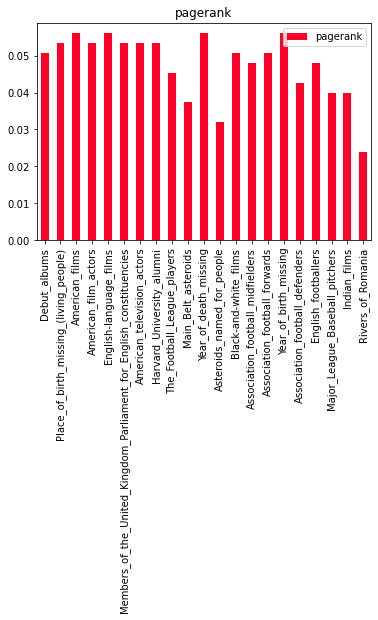

In [189]:
plot_values(df)